In [1]:
import os
import pandas as pd
import sklearn
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [2]:
data = pd.read_csv('Australian Vehicle Prices.csv')

In [3]:
data.head(4)

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990


In [4]:
def create_advanced_features(df):
    df_processed = df.copy()
    luxury_brands = ['mercedes-benz', 'bmw', 'audi', 'lexus', 'porsche']
    premium_brands = ['volkswagen', 'volvo', 'subaru', 'mini']
    economy_brands = ['toyota', 'honda', 'mazda', 'hyundai', 'kia']
    
    df_processed['brand_category'] = df_processed['Brand'].str.lower().apply(
        lambda x: 'luxury' if x in luxury_brands else
                  'premium' if x in premium_brands else
                  'economy' if x in economy_brands else 'standard'
    )
    
    df_processed['base_depreciation'] = 1 / (1 + 0.2 * df_processed['Age'])
    
    depreciation_multipliers = {
        'luxury': 0.85,
        'premium': 0.9,
        'economy': 0.95,
        'standard': 0.92
    }
    
    df_processed['adjusted_depreciation'] = df_processed.apply(
        lambda row: row['base_depreciation'] * depreciation_multipliers[row['brand_category']], axis=1
    )
    
    df_processed['model_frequency'] = df_processed.groupby('Model')['Model'].transform('count')
    df_processed['brand_frequency'] = df_processed.groupby('Brand')['Brand'].transform('count')
    
    df_processed['model_rarity'] = 1 / np.log1p(df_processed['model_frequency'])
    df_processed['brand_popularity'] = df_processed['brand_frequency'] / len(df_processed)
    
    df_processed['depreciation_score'] = (
        df_processed['adjusted_depreciation'] * 
        (1 + df_processed['model_rarity']) * 
        (1 + df_processed['brand_popularity'])
    )
    
    mileage_impact_multipliers = {
        'luxury': 1.2,
        'premium': 1.1,
        'economy': 0.9,
        'standard': 1.0
    }
    
    df_processed['mileage_impact'] = df_processed.apply(
        lambda row: (row['KmPerYear'] / 20000) * mileage_impact_multipliers[row['brand_category']],
        axis=1
    )
    
    df_processed['market_value_indicator'] = (
        df_processed['depreciation_score'] * 
        (1 - df_processed['mileage_impact']) * 
        (1 + df_processed['model_rarity'])
    )
    
    return df_processed

def preprocess_data(df):
    print("\nStarting enhanced data preprocessing...")
    df_processed = df.copy()
    
    # Extract numerical data
    df_processed['CylindersinEngine'] = df_processed['CylindersinEngine'].astype(str).str.extract('(\d+)').astype(float)
    
    # Clean price column and log-transform
    df_processed['Price'] = pd.to_numeric(df_processed['Price'].astype(str).str.replace('[$,]', ''), errors='coerce')
    df_processed['Price_Log'] = np.log1p(df_processed['Price'])
    
    # Remove outliers using z-scores
    price_z_scores = np.abs((df_processed['Price'] - df_processed['Price'].mean()) / df_processed['Price'].std())
    df_processed = df_processed[price_z_scores < 3]
    
    # Segment cars by average price
    model_avg_prices = df_processed.groupby('Model')['Price'].transform('mean')
    df_processed['market_segment_score'] = pd.qcut(
        model_avg_prices, q=5, labels=[1, 2, 3, 4, 5]
    ).astype(float)
    
    df_processed['segment_competition'] = df_processed.groupby('market_segment_score')['Model'].transform('count')
    df_processed['market_position'] = df_processed['market_segment_score'] * (1 / np.log1p(df_processed['segment_competition']))
    
    # Add derived features
    df_processed['Age'] = 2024 - df_processed['Year']
    df_processed['Age_Squared'] = df_processed['Age'] ** 2
    df_processed['Kilometres'] = pd.to_numeric(df_processed['Kilometres'].astype(str).str.replace(',', ''), errors='coerce')
    df_processed['KmPerYear'] = df_processed['Kilometres'] / df_processed['Age'].replace(0, 1)
    df_processed['KmPerYear_Log'] = np.log1p(df_processed['KmPerYear'])
    
    # Encode 'UsedOrNew'
    df_processed['IsNew'] = (df_processed['UsedOrNew'].str.upper() == 'NEW').astype(int)
    df_processed['IsDemo'] = (df_processed['UsedOrNew'].str.upper() == 'DEMO').astype(int)
    df_processed['IsUsed'] = (~df_processed['UsedOrNew'].str.upper().isin(['NEW', 'DEMO'])).astype(int)
    
    # Extract engine size and fuel consumption
    df_processed['EngineSize'] = df_processed['Engine'].str.extract(r'(\d+\.?\d*)\s*L').astype(float)
    df_processed['FuelConsumption_Numeric'] = df_processed['FuelConsumption'].str.extract(r'(\d+\.?\d*)').astype(float)
    
    # Encode premium brand and vehicle type
    df_processed['Premium_Brand'] = df_processed['Brand'].isin(['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Porsche']).astype(int)
    df_processed['Is_SUV'] = df_processed['BodyType'].str.contains('SUV', na=False).astype(int)
    
    # Extract numerical values for 'Doors' and 'Seats'
    df_processed['Doors'] = df_processed['Doors'].astype(str).str.extract('(\d+)').astype(float)
    df_processed['Seats'] = df_processed['Seats'].astype(str).str.extract('(\d+)').astype(float)
    
    # Add advanced features
    df_processed = create_advanced_features(df_processed)
    
    # Define features and target variable
    features = [
        'Brand', 'Age', 'Age_Squared', 'BodyType', 'Transmission', 'DriveType',
        'KmPerYear_Log', 'CylindersinEngine', 'Doors', 'Seats',
        'IsNew', 'IsDemo', 'IsUsed', 'Premium_Brand', 'Is_SUV',
        'EngineSize', 'FuelConsumption_Numeric', 'market_position',
        'depreciation_score', 'market_value_indicator', 'model_rarity', 'brand_popularity'
    ]
    
    # Encode categorical features
    categorical_features = ['Brand', 'BodyType', 'Transmission', 'DriveType']
    for feature in categorical_features:
        if feature in features:
            df_processed[feature] = df_processed[feature].fillna('Unknown')
            le = LabelEncoder()
            df_processed[feature] = le.fit_transform(df_processed[feature].astype(str))
    
    # Fill missing values for numeric features
    numeric_features = [f for f in features if df_processed[f].dtype in ['int64', 'float64']]
    for feature in numeric_features:
        if feature in df_processed.columns:
            df_processed[feature].fillna(df_processed[feature].median(), inplace=True)
    
    X = df_processed[features]
    y = df_processed['Price_Log']
    
    print(f"Preprocessed data shape: X: {X.shape}, y: {y.shape}")
    return X, y

# Preprocess the data
X, y = preprocess_data(data)



Starting enhanced data preprocessing...


C:\Users\onurk\AppData\Local\Temp\ipykernel_25972\3131639589.py:66: FutureWarning: The default value of regex will change from True to False in a future version.
  df_processed['Price'] = pd.to_numeric(df_processed['Price'].astype(str).str.replace('[$,]', ''), errors='coerce')


Preprocessed data shape: X: (16443, 22), y: (16443,)


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Print results
print("Linear Regression Results:")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train R2: {train_r2:.2f}")
print(f"Test R2: {test_r2:.2f}")



Linear Regression Results:
Train RMSE: 0.30
Test RMSE: 0.30
Train R2: 0.78
Test R2: 0.78


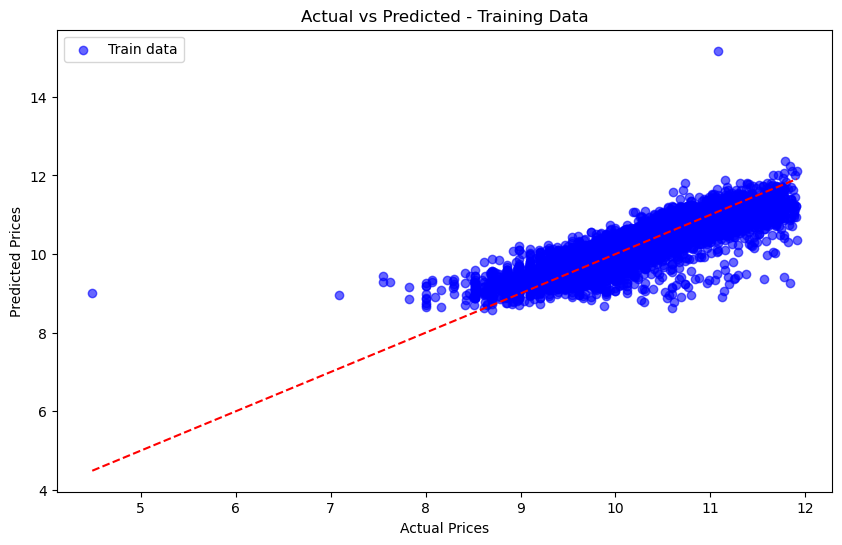

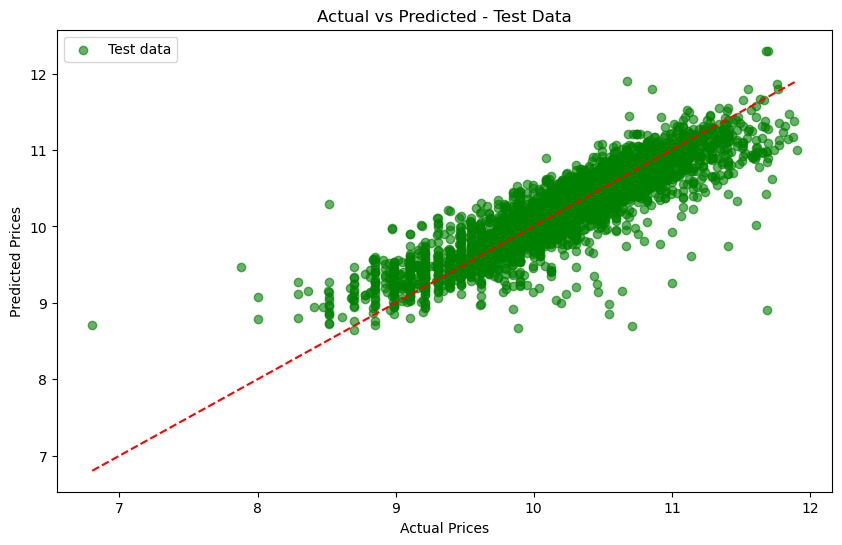

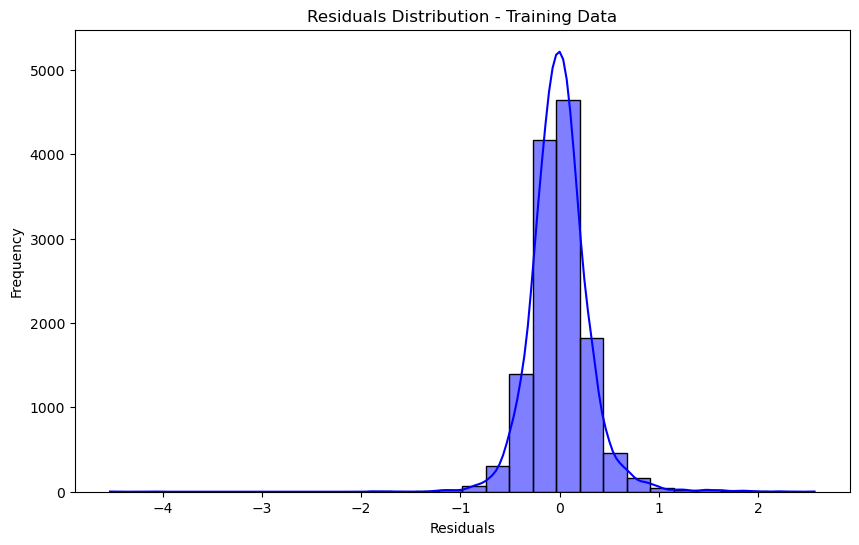

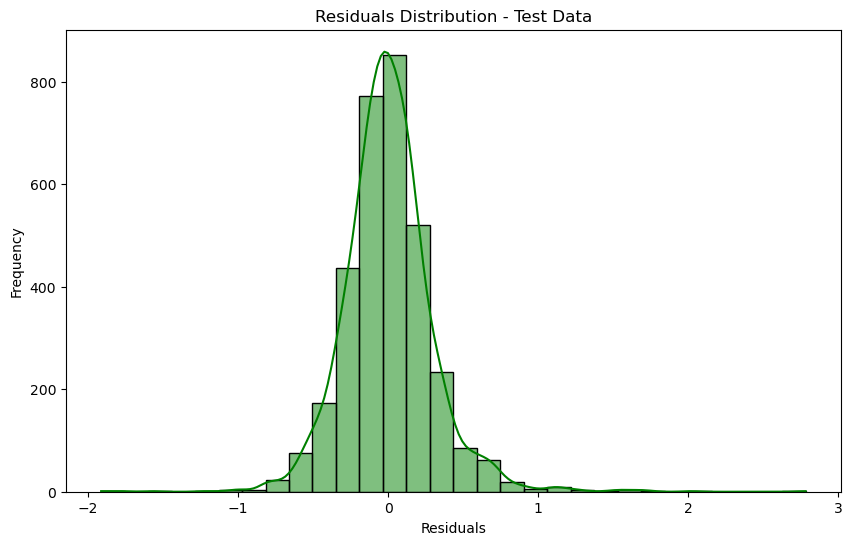

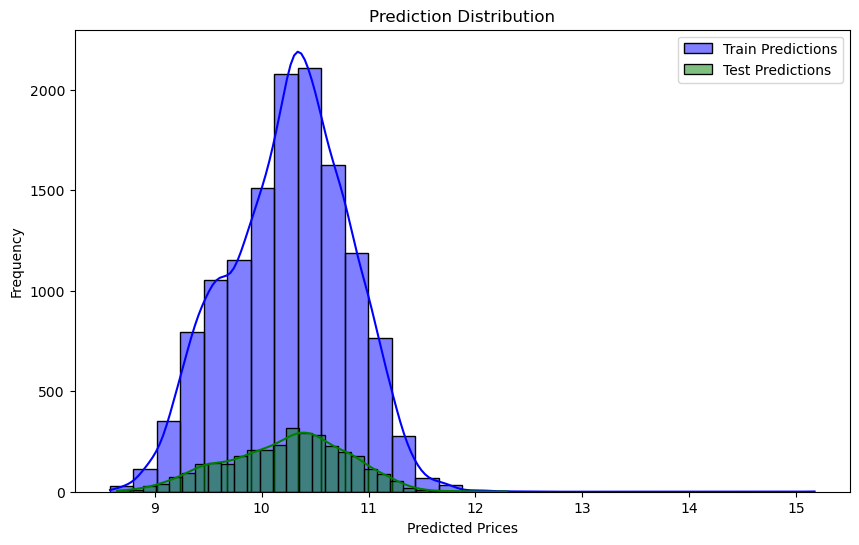

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot actual vs predicted values for training data
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.6, label="Train data")
plt.title('Actual vs Predicted - Training Data')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')  # Perfect prediction line
plt.legend()
plt.show()

# Plot actual vs predicted values for test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='green', alpha=0.6, label="Test data")
plt.title('Actual vs Predicted - Test Data')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Perfect prediction line
plt.legend()
plt.show()

# Residuals plot for training data
plt.figure(figsize=(10, 6))
residuals_train = y_train - y_pred_train
sns.histplot(residuals_train, kde=True, color='blue', bins=30)
plt.title('Residuals Distribution - Training Data')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residuals plot for test data
plt.figure(figsize=(10, 6))
residuals_test = y_test - y_pred_test
sns.histplot(residuals_test, kde=True, color='green', bins=30)
plt.title('Residuals Distribution - Test Data')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of predictions
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_train, color='blue', kde=True, label="Train Predictions", bins=30)
sns.histplot(y_pred_test, color='green', kde=True, label="Test Predictions", bins=30)
plt.title('Prediction Distribution')
plt.xlabel('Predicted Prices')
plt.ylabel('Frequency')
plt.legend()
plt.show()


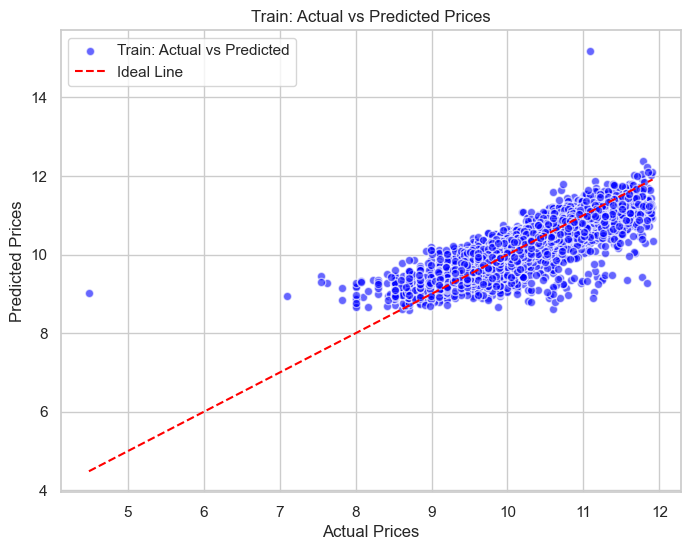

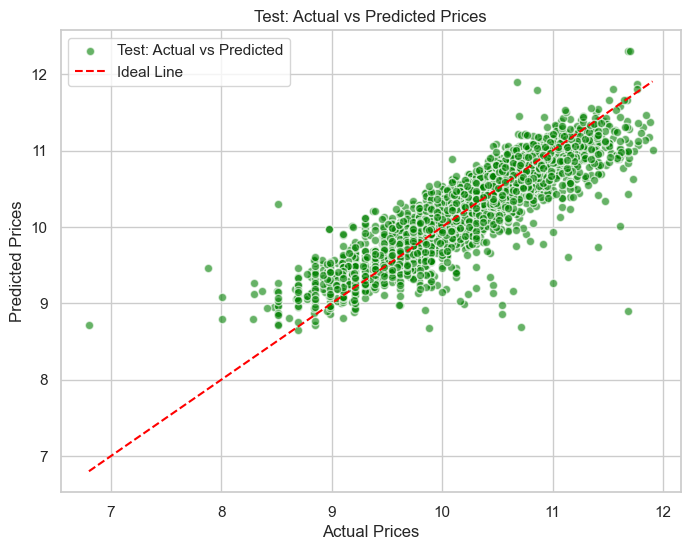

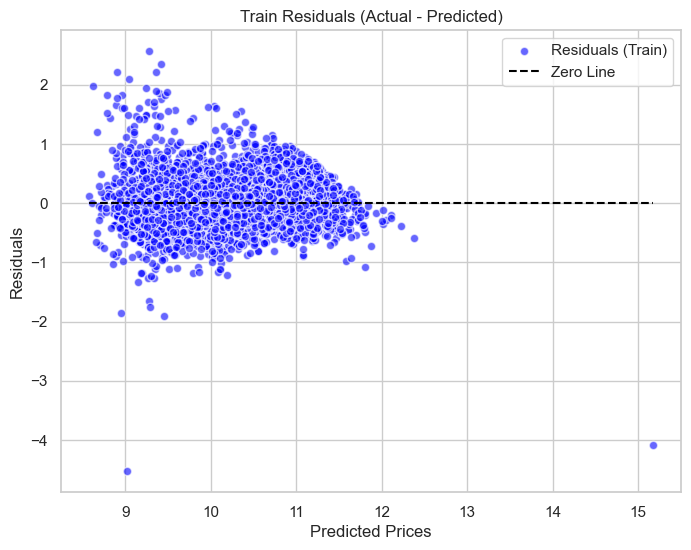

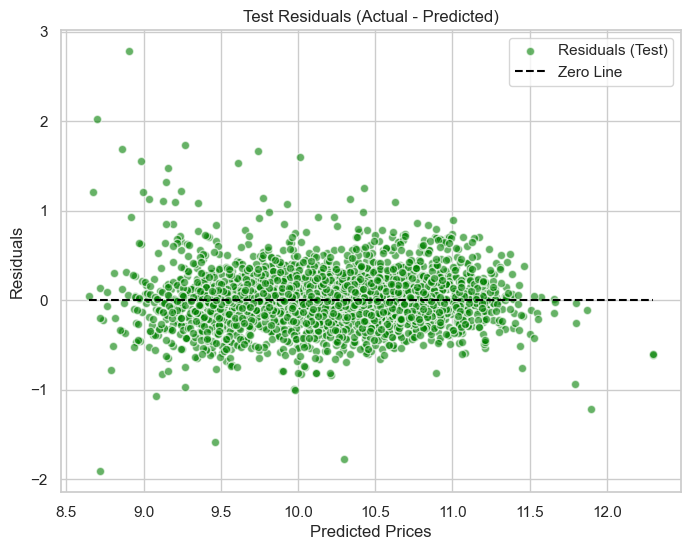

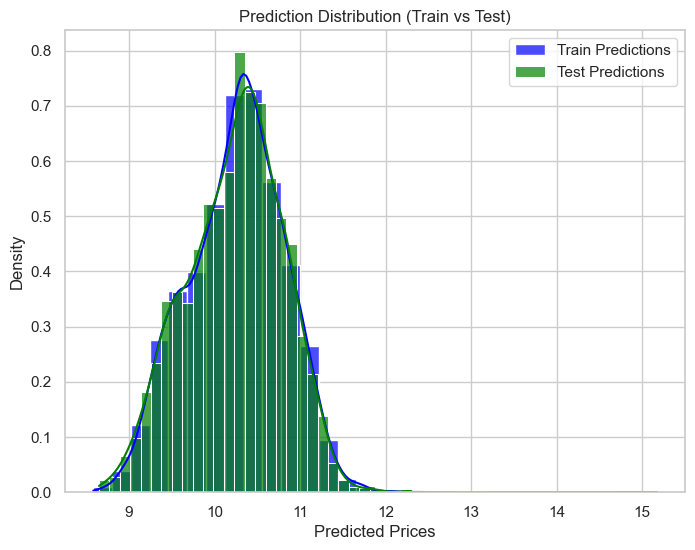

In [10]:

# Set up the style for seaborn
sns.set(style="whitegrid")

# 1. Train: Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.6, edgecolors='w', label='Train: Actual vs Predicted')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Ideal Line')
plt.title('Train: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()

# 2. Test: Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, color='green', alpha=0.6, edgecolors='w', label='Test: Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.title('Test: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()

# 3. Residuals for Train set
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, y_train - y_pred_train, color='blue', alpha=0.6, edgecolors='w', label='Residuals (Train)')
plt.hlines(y=0, xmin=min(y_pred_train), xmax=max(y_pred_train), color='black', linestyle='--', label='Zero Line')
plt.title('Train Residuals (Actual - Predicted)')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# 4. Residuals for Test set
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, y_test - y_pred_test, color='green', alpha=0.6, edgecolors='w', label='Residuals (Test)')
plt.hlines(y=0, xmin=min(y_pred_test), xmax=max(y_pred_test), color='black', linestyle='--', label='Zero Line')
plt.title('Test Residuals (Actual - Predicted)')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# 5. Prediction Distribution (for both Train and Test)
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_train, color='blue', kde=True, stat="density", label='Train Predictions', bins=30, alpha=0.7)
sns.histplot(y_pred_test, color='green', kde=True, stat="density", label='Test Predictions', bins=30, alpha=0.7)
plt.title('Prediction Distribution (Train vs Test)')
plt.xlabel('Predicted Prices')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
